# Self-Driving Car Engineer Nanodegree


### Project: Finding Lane Lines on the Road

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import random
from IPython.core.display import display
%matplotlib inline

from moviepy.editor import VideoFileClip
from IPython.display import display, HTML

In [2]:
image = mpimg.imread('C:/Users/Sharath/Desktop/SDND-Term-1/test_images/solidWhiteRight.jpg')

In [3]:
print('This image is:', type(image), 'with dimensions:', image.shape)

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


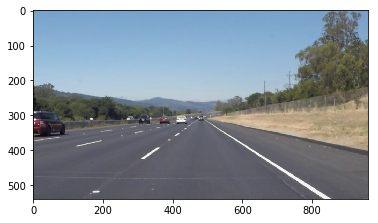

In [4]:
plt.imshow(image) 

# Ideas For Detection of Lane - Pipeline

Some words about Computer Vision Libraray.

OpenCV has an excellent documentation to read about for processing images in Python

cv2.inRange() for selecting colors
cv2.fillPoly() for Selecting the various regions
cv2.line() to draw the lines on any image within the given endpoints
cv2.addWeighted() to coadd/ overlay two images 
cv2.Color() to convert grayscale image into colored one
cv2.imwrite() to output the image into a file

# Helper Functions

Some these functions were given to us in the lesson.

Now before anyu further, Lets design a function that feeds in  a image and spits out the grayscale image. 

Assuming your grayscaled image is called 'gray'
lets call plt.imshow(gray, cmap='gray') to verify if its a Gray scale image

#### Point to be noted:

#### 1. Alternately we can use BGR2GRAY if we had to  read an image with cv2.imread() 
#### 2. Return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

In [5]:
def grayscale(img):
    return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

Lets Apply the Canny Transform to get the edge mdetection working

In [6]:
def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

Lets Apply a Gaussian Blur to condition the image.In blurring, we simple reduce the edge content and makes the transition form one color to the other very smooth. 

In [7]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img,(kernel_size, kernel_size), 0)

Lets next create an image mask.
A mask is a filter. Concept of masking is also known as spatial filtering. Masking is also known as filtering. In this concept we just deal with the filtering operation that is performed directly on the 

To Do:

1.Define a blank mask

2.Define 3-channel or a single channel color to fioo the mask with resprect to the image

3.We would also want to want to fill the pixels inside the polygon filter defined by verticed while filling the colors.

4.Atlast we would want to return the image where the mask pixels are non zero

The first step is to define a region-of-interest (ROI) wherein we would search for potential line markings. I selected a triangle shaped ROI which I parametrized with respect to the image height and width in order to make it adaptable to different images and video where the camera would be placed at a different location. 

In [8]:
def region_of_interest(img, vertices):
    mask = np.zeros_like(img)
    if len(img.shape) > 2 :
        channel_count = img.shape[2]
        ignore_mask = (255,) * channel_count
    else:
        ignore_mask = 255
        
    cv2.fillPoly(mask,vertices, ignore_mask)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image



Lets Now create a function which can create or draw lines in our picture.

The next step would naturally be drawing lines on the processed image ie, blurred and filtered image. 

This is the function you might want to use as a starting point once you want to 
average/extrapolate the line segments you detect to map out the full extent of the lane.

Think about things like separating line segments by their 
slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left line vs. the right line. Then, you can average the position of each of the lines and extrapolate to the top and bottom of the lane. 
 
This function draws `lines` with `color` and `thickness`.Lines are drawn on the image inplace (mutates the image).If you want to make the lines semi-transparent, think about combining his function with the weighted_img() function below



In [26]:
def draw_lines(img, lines, color=[0, 0, 255], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_lanes_lines = []
    right_lanes_lines = []

    ##The average is easier to compute in slope intercept form.
    ## The average of slopes and average of intercepts of all lines is
    ## a good representation of the line.
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            #intercept = y1 - slope*x1
            
            if slope < -0.4 and slope > -0.9:
                left_lanes_lines.append((x1, y1, x2, y2))
            if (slope > 0.4 and slope <.9):
                right_lanes_lines.append((x1, y1, x2, y2))

    left_lane_detection = [sum(y) / len(y) for y in zip(*left_lanes_lines)]
    right_lane_detection = [sum(y) / len(y) for y in zip(*right_lanes_lines)]

    if left_lane_detection is not None and len(left_lane_detection) > 0:
        slope = (left_lane_detection[3]-left_lane_detection[1])/ (left_lane_detection[2]-left_lane_detection[0])
        intercept = left_lane_detection[1] - slope*left_lane_detection[0]

        y1 = img.shape[0]  # bottom of the image
        y2 = int(y1 * 0.58) #top of line, similar to mask height
        x1 = int((y1 - intercept) / slope)
        x2 = int((y2 - intercept) / slope)

        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
        #cv2.line(img, (left_lane[0], left_lane[1]), (left_lane[2], left_lane[3]), color, thickness)

    if right_lane_detection is not None and len(right_lane_detection) > 0:
        slope = (right_lane_detection[3] - right_lane_detection[1]) / (right_lane_detection[2] - right_lane_detection[0])
        intercept = right_lane_detection[1] - slope * right_lane_detection[0]

        y1 = img.shape[0]  # bottom of the image
        y2 = int(y1 * 0.58)
        x1 = int((y1 - intercept) / slope)
        x2 = int((y2 - intercept) / slope)
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

`img` should be the output of a Canny transform.
        
 Returns an image with hough lines drawn.

In [27]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype = np.uint8)
    draw_lines(line_img, lines)
    return line_img


We change the image into a weighted image, in order to make it a black image and place the lines.

`img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    initial_img should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ 
    
    NOTE: initial_img and img must be the same shape!

In [28]:
def weighted_img(img, intial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(intial_img, α, img, β, λ)

# Test Image

Lets put our pipeline to work in our directory.
Lets try and  make sure your pipeline works well on these images before you try the videos.

In [29]:
import os
os.listdir("C:/Users/Sharath/Desktop/SDND-Term-1/test_images")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

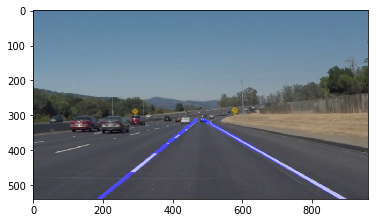

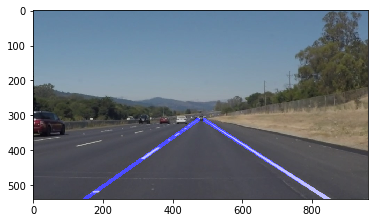

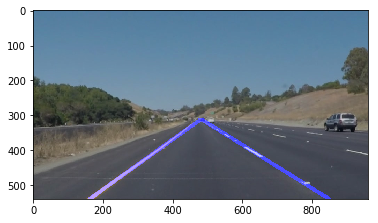

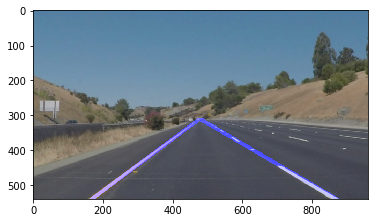

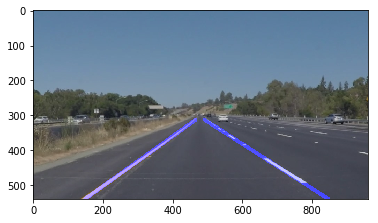

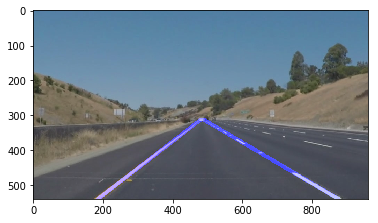

In [30]:
for i, img in enumerate(os.listdir("C:/Users/Sharath/Desktop/SDND-Term-1/test_images")):
    image = mpimg.imread('C:/Users/Sharath/Desktop/SDND-Term-1/test_images/' + img)

    gray_image = grayscale(image)        
    kernel_size = 11
    blur_gray = gaussian_blur(image,kernel_size)
    low_threshold = 50
    high_threshold = 150
    edges = canny(blur_gray, low_threshold, high_threshold)
    
    
    vertices = np.array([[(0,540),(460.79999, 313.2),
                          (499.2, 313.2 ), (960, 540)]], dtype=np.int32)
    
    # These Values are based ion trail and error to choose the perfect apex and vertices of the triangle i.e Region of Interest
    masked_edges = region_of_interest(edges,vertices)
        
    # Define the Hough transform parameters
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_length = 40
    max_line_gap = 300

    # Run Hough on edge detected image
    lines = hough_lines(masked_edges, rho, theta, threshold,
                            min_line_length, max_line_gap)

    # Draw the lines on the edge image
    result = weighted_img(lines, image)
    plt.figure()
    plt.imshow(result)
    

An obvious choice is to use edge detection to identify the markings, however, in cases where additional edges are present due to shadows or reflections on the road then this approach will yield many false lines. Hence, in order to overcome this approach I fuse the edge detection results with color processing. The color processing is performed in two different ways. First, any yellow lanes are detected in the HLS space using the COLOR_RGB2HLS in opencv, and then any white white lanes are detected in same manner.

# Lets look at the Sample Images that we have got.

## Build a Lane Finding Pipeline
Build the pipeline and run your solution on all test_images. Make copies into the test_images_output directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [31]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from IPython.display import display

#### Lets Make the Vertices variables of our triangle or the **Region of Interest** , more dynamic as we may not always have an image with *540 x 960*

In [32]:
image_shape = image.shape
vertices_coordinates = np.array([[(0,image_shape[0]),(image_shape[1]*.48, image_shape[0]*.58),
                          (image_shape[1]*.52, image_shape[0]*.58), (image_shape[1],image_shape[0])]], dtype=np.int32)

In [33]:
def process_image(image):

    gray_image = grayscale(image) 
    
    kernel_size = 11
    blur_gray_settings = gaussian_blur(image,kernel_size)
    low_threshold_value = 50
    high_threshold_value = 150
    edges = canny(blur_gray_settings, low_threshold_value, high_threshold_value)
    
    
    
    masked_edges = region_of_interest(edges,vertices_coordinates)
        
    # Define the Hough transform parameters
    rho = 1
    theta = np.pi/180
    threshold = 20
    min_line_length = 40
    max_line_gap = 300   #max gap in pixels btwn connectable line segments


    # Run Hough on edge detected image
    lines = hough_lines(masked_edges, rho, theta, threshold,
                            min_line_length, max_line_gap)

    # Draw the lines on the edge image
    result = weighted_img(lines, image)
    
    return result

In [34]:
clip1 = VideoFileClip("C:/Users/Sharath/solidWhiteRight.mp4")

In [35]:
white_output = 'C:/Users/Sharath/solidWhiteRight2.mp4'

In [19]:
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video C:/Users/Sharath/solidWhiteRight2.mp4
[MoviePy] Writing video C:/Users/Sharath/solidWhiteRight2.mp4


100%|███████████████████████████████████████████████████████████████████████████████▋| 221/222 [00:06<00:00, 35.71it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:/Users/Sharath/solidWhiteRight2.mp4 

Wall time: 6.58 s


In [20]:
clip2 = VideoFileClip('C:/Users/Sharath/solidYellowLeft.mp4')

In [21]:
yellow_output = 'C:/Users/Sharath/solidYellowLeft2.mp4'

In [22]:
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video C:/Users/Sharath/solidYellowLeft2.mp4
[MoviePy] Writing video C:/Users/Sharath/solidYellowLeft2.mp4


100%|███████████████████████████████████████████████████████████████████████████████▉| 681/682 [00:18<00:00, 37.36it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:/Users/Sharath/solidYellowLeft2.mp4 

Wall time: 18.6 s


In [23]:
clip3 = VideoFileClip('C:/Users/Sharath/challenge.mp4')

In [24]:
challenge_op = 'C:/Users/Sharath/challenge2.mp4'

In [25]:
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_op, audio=False)

[MoviePy] >>>> Building video C:/Users/Sharath/challenge2.mp4
[MoviePy] Writing video C:/Users/Sharath/challenge2.mp4


100%|████████████████████████████████████████████████████████████████████████████████| 251/251 [00:12<00:00, 20.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: C:/Users/Sharath/challenge2.mp4 

Wall time: 13.1 s
